In [1]:
import sklearn

#NN Surrogate model class
from injector_surrogate_quads import *

from emittance_calc import getNormEmit
from sampling_functions import getGroundTruth, getBeamsize

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#BO
from bayes_opt import BayesianOptimization

# Load injector model

In [2]:
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'modelsmodel_OTR2_NA_rms_emit_elu_2021-07-27T19:54:57-07:00')
Model.load_scaling()
Model.take_log_out = False

energy = 0.135 #GeV

# Set up sampling and objectives

In [3]:
#convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

In [4]:
ref_point = ref_point[0]

In [5]:
#input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','SQ01:b1_gradient','CQ01:b1_gradient','QE04:b1_gradient']

#output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(varx,vary,varz,varscan=[-5,-4,-3,-2,-1,0]): 
    numscan = len(varscan)
    
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((numscan,len(Model.model_in_list)))
    
    #fill in reference point around which to optimize
    for i in range(0,len(ref_point)):
        x_in[:,i]=ref_point[i] 

    #set solenoid, SQ, CQ to values from optimization step
    x_in[:, Model.loc_in[opt_var_names[0]]] = varx
    x_in[:, Model.loc_in[opt_var_names[1]]] = vary
    x_in[:, Model.loc_in[opt_var_names[2]]] = varz
    
    #set quad 525 to values for scan
    x_in[:, Model.loc_in[opt_var_names[3]]] = varscan

    #output predictions
    y_out = Model.pred_machine_units(x_in) 
    
    emitx = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    emity = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    
    print(np.mean(emitx)/1e-6, np.mean(emity)/1e-6)
    #plt.plot(x_in[:,Model.loc_in['QE04:b1_gradient']],y_out[:,0], label="sig_x")
    #plt.plot(x_in[:,Model.loc_in['QE04:b1_gradient']],y_out[:,1], label="sig_y")
    
    x_rms = y_out[:,0]
    y_rms = y_out[:,1]

    norm_emit = getNormEmit(energy, varscan, x_rms, y_rms) #normalized emittance

    # return emit predicted, norm geo emit calc, norm emit x and y
    #return -1*objective(y_out)[0], -np.sqrt(emitx*emity)/1e-6, emitx/1e-6, emity/1e-6
#     if np.isnan(np.sqrt(emitx*emity)):
#         return -1000
    return  -norm_emit/1e-6


# def objective(y_out):
    
#     #output is geometric emittance in transverse plane
#     out1 = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
#     out2 = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    
#     return np.sqrt(out1*out2)/1e-6 # in um units

1.2320274436206091 1.5167329365795013
nemitx 3.47 nemity 264185974328.22


-1000000000.0

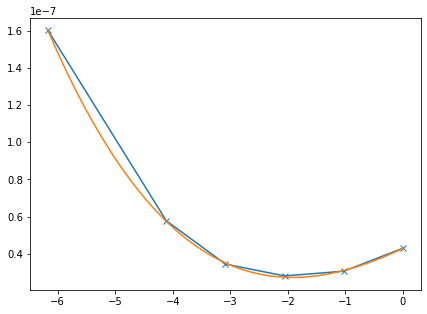

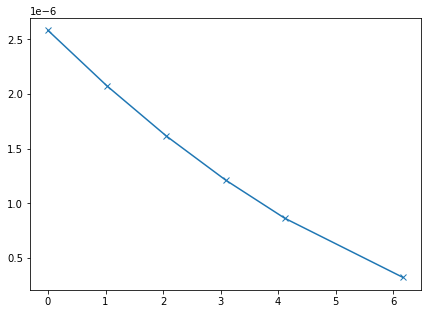

In [27]:
# x axis works around focus
evaluate(0.4657, -0.0071, -0.0169, [-3, -2, -1.5, -1,-0.5, 0])



1.281426534660568 1.5350985904660774
nemitx 98.43 nemity 264185974328.22


-1000000000.0

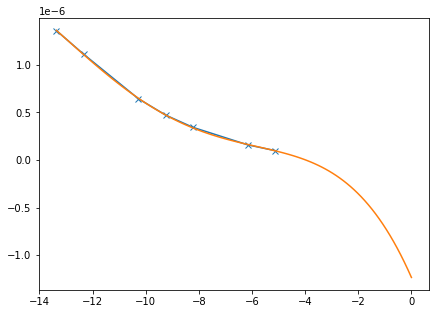

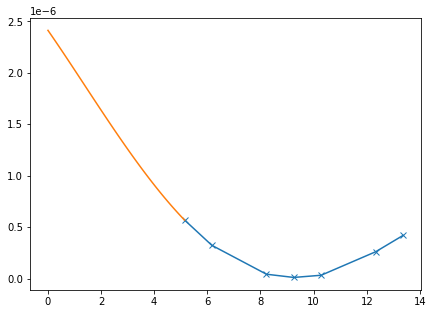

In [6]:
evaluate(0.4657, -0.0071, -0.0169, [  -6.5, -6,  -5, -4.5, -4, -3, -2.5])


1.3624251096189255 1.6438663124063169
nemitx 264185974328.22 nemity 264185974328.22


-1000000000.0

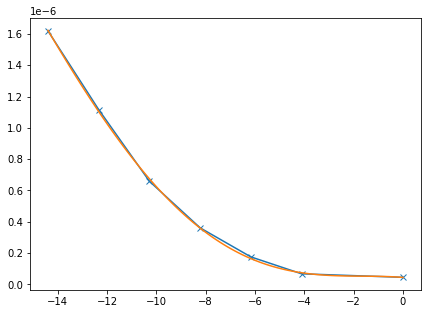

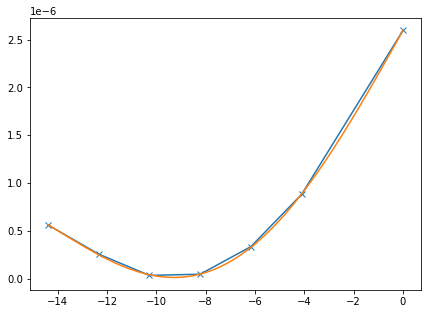

In [12]:
evaluate( 0.4657  , -0.007063 , -0.01989, [-7,-6,  -5, -4, -3, -2, 0 ])


# Simple BO 

|   iter    |  target   |   varx    |   vary    |   varz    |
-------------------------------------------------------------
0.9321835818809632 1.4024145684743416
nemitx 13.73 nemity 264185974328.22
|  1        | -1e+09    |  0.4859   |  0.008813 | -0.02     |
1.0447175782246632 1.167589402939484
nemitx 1.90 nemity 16.59
|  2        | -5.617    |  0.4733   | -0.01413  | -0.01631  |
1.1267657100688666 1.2724804037134163
nemitx 264185974328.22 nemity 37.29
|  3        | -1e+09    |  0.4605   | -0.006178 | -0.004129 |
2.3894888272479875 1.631190912121383
nemitx 264185974328.22 nemity 264185974328.22
|  4        | -1e+09    |  0.4993   | -0.003232 |  0.007409 |
0.8708514656063926 1.20389040603186
nemitx 264185974328.22 nemity 70.74
|  5        | -1e+09    |  0.4625   |  0.01512  | -0.0189   |
0.9086043633033114 1.0051447816294967
nemitx 2.58 nemity 264185974328.22
|  6        | -1e+09    |  0.4813   |  0.0116   |  0.01098  |
1.2366979262878885 2.505114025552757
nemitx 264185974328.22 nemity

/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

nemitx 2.13 nemity 18.17
|  12       | -6.216    |  0.473    | -0.01113  | -0.01717  |
2.35104926105123 2.1849853055755375
nemitx 264185974328.22 nemity 264185974328.22
|  13       | -1e+09    |  0.4938   |  0.01365  |  0.01916  |
1.0206736078544054 1.1243309927522205
nemitx 2.21 nemity 12.40
|  14       | -5.24     |  0.4757   | -0.01174  | -0.01879  |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

5.499699909705669 3.042333219127613
nemitx 143.03 nemity 264185974328.22
|  15       | -1e+09    |  0.534    |  0.008774 |  0.01648  |
0.8684212957632553 0.9026493330566154
nemitx 2.58 nemity 9.45
|  16       | -4.942    |  0.4774   | -0.01133  | -0.01266  |
0.7795524084031058 0.8041620276344474
nemitx 2.79 nemity 15.72
|  17       | -6.627    |  0.4785   | -0.004292 | -0.0133   |
0.986372583611228 1.1455171033958322
nemitx 2.17 nemity 19.29
|  18       | -6.463    |  0.4727   | -0.01074  | -0.01695  |
4.987741249351529 5.18806928084814
nemitx 69.30 nemity 264185974328.22
|  19       | -1e+09    |  0.5433   |  0.018    | -0.008835 |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

0.6576420332748967 0.7195458238129504
nemitx 0.74 nemity 15.66
|  20       | -3.402    |  0.4741   | -0.005142 | -0.00833  |
0.8132590778586746 1.0631383702275343
nemitx 1.99 nemity 21.01
|  21       | -6.467    |  0.4719   | -0.000865 | -0.01854  |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

0.7499094749618962 0.716289548563509
nemitx 8.77 nemity 264185974328.22
|  22       | -1e+09    |  0.482    | -0.00757  | -0.004374 |
0.645038028324052 0.8021634698707203
nemitx 1.04 nemity 24.19
|  23       | -5.006    |  0.4725   |  0.001323 | -0.01177  |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

0.9379512562190939 1.1965535122726578
nemitx 2.24 nemity 26.00
|  24       | -7.636    |  0.4678   | -0.002816 | -0.01491  |
7.106737029971555 5.554079052672023
nemitx 264185974328.22 nemity 264185974328.22
|  25       | -1e+09    |  0.55     | -0.02     | -0.02     |
0.8857873581291642 0.9170416319648211


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

nemitx 2.73 nemity 8.60
|  26       | -4.844    |  0.4777   | -0.0115   | -0.01281  |
1.0355885251556174 0.8867379506227735
nemitx 264185974328.22 nemity 264185974328.22
|  27       | -1e+09    |  0.4653   | -0.01741  |  0.008154 |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))


2.7950552521360805 2.4345679321413627
nemitx 264185974328.22 nemity 264185974328.22
|  28       | -1e+09    |  0.44     |  0.02     |  0.02     |
7.69591406424297 2.7959438284597127
nemitx 77.03 nemity 264185974328.22
|  29       | -1e+09    |  0.5473   | -0.01993  |  0.01597  |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

5.010053428122774 3.937623660021927
nemitx 124.81 nemity 264185974328.22
|  30       | -1e+09    |  0.5323   | -0.00326  | -0.008156 |
5.491021511261351 1.3420766435956466
nemitx 264185974328.22 nemity 264185974328.22
|  31       | -1e+09    |  0.5164   | -0.02     |  0.02     |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

1.6858333538039005 1.7149022824014537
nemitx 264185974328.22 nemity 517.66
|  32       | -1e+09    |  0.44     | -0.02     |  0.02     |
4.509474365477217 3.694756060212967
nemitx 100.11 nemity 264185974328.22
|  33       | -1e+09    |  0.515    | -0.02     | -0.02     |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

0.7134956945265003 0.8396717134928622
nemitx 1.00 nemity 18.98
|  34       | -4.353    |  0.4734   | -0.003707 | -0.01264  |
0.6348609531414695 0.7114786626516434
nemitx 264185974328.22 nemity 28.17
|  35       | -1e+09    |  0.4711   |  0.005002 | -0.003556 |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

1.044029090735421 1.0319207603970426
nemitx 264185974328.22 nemity 39.39
|  36       | -1e+09    |  0.464    |  0.009655 |  0.001415 |
1.7416369928469067 2.0114919152547373
nemitx 264185974328.22 nemity 264185974328.22
|  37       | -1e+09    |  0.4514   | -0.01771  | -0.005214 |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

1.0805161991811474 1.4220255479813204
nemitx 4.98 nemity 32.80
|  38       | -12.78    |  0.4651   |  0.001101 | -0.01932  |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))


1.5788072005307185 1.884115022221522
nemitx 264185974328.22 nemity 264185974328.22
|  39       | -1e+09    |  0.4538   |  0.000751 | -0.01994  |
0.665635980112711 0.9611241011953098
nemitx 1.58 nemity 33.81
|  40       | -7.32     |  0.4708   |  0.007149 | -0.01655  |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

2.7301066438667476 4.689250090450514
nemitx 94.84 nemity 264185974328.22
|  41       | -1e+09    |  0.5218   |  0.01886  | -0.01913  |
1.981981995413662 1.813983658394136
nemitx 264185974328.22 nemity 90.97
|  42       | -1e+09    |  0.4407   |  0.01899  | -0.004778 |
5.507495643541915 4.456477199710207


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.py

nemitx 99.00 nemity 264185974328.22
|  43       | -1e+09    |  0.5317   | -0.01504  | -0.01855  |
6.523579941131175 4.022203484055353
nemitx 8.11 nemity 264185974328.22
|  44       | -1e+09    |  0.55     |  0.02     |  0.02     |
0.6710631623718655 0.9884257679004804
nemitx 0.68 nemity 45.48
|  45       | -5.578    |  0.468    |  0.01382  | -0.01477  |


/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))
/Users/smiskov/Documents/SLAC/lcls_cu_injector_ml_model/injector_surrogate/emittance_calc.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,5))


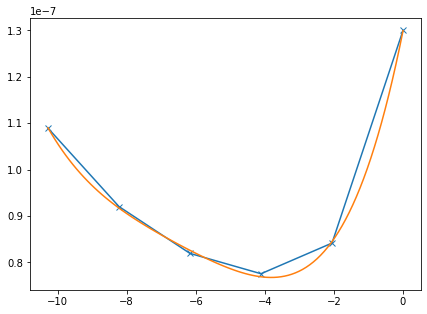

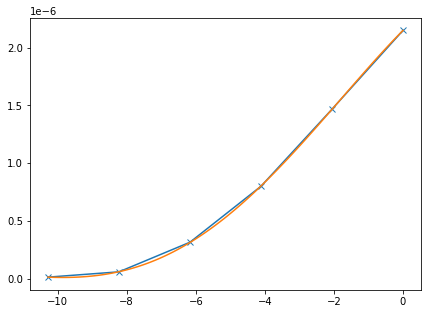

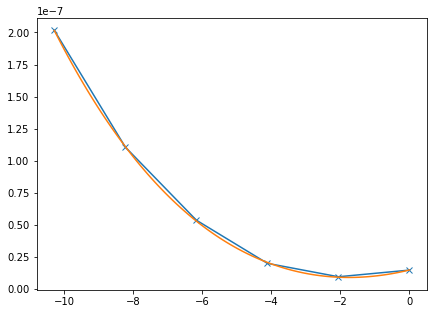

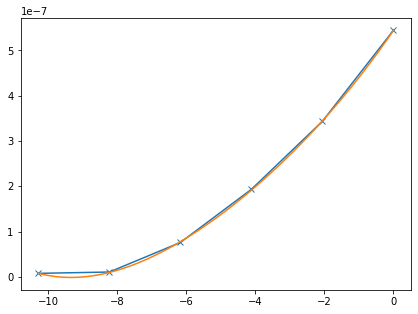

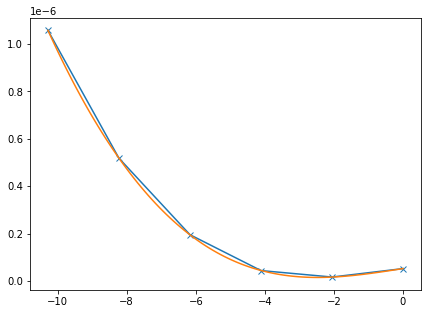

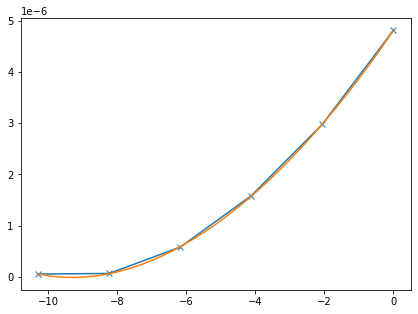

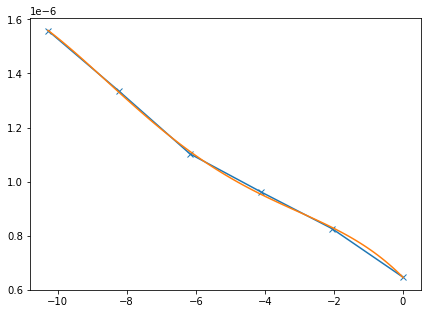

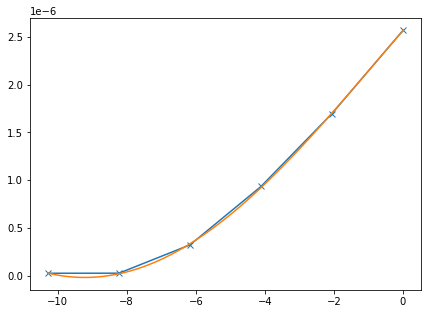

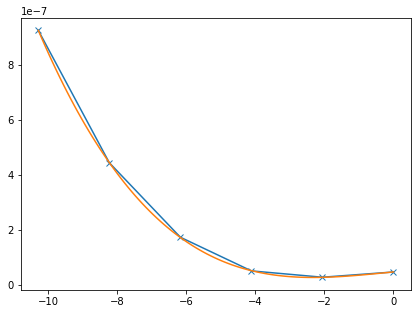

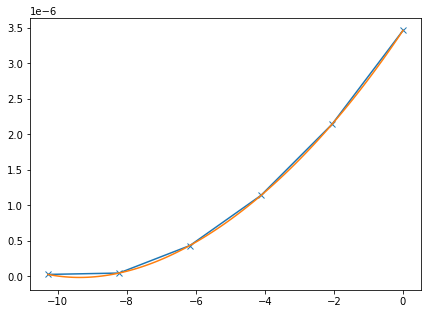

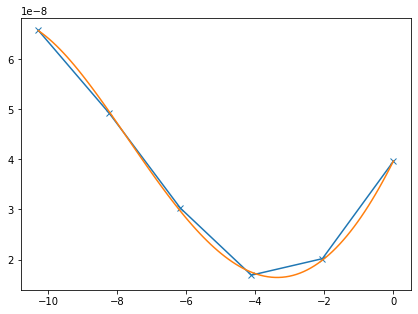

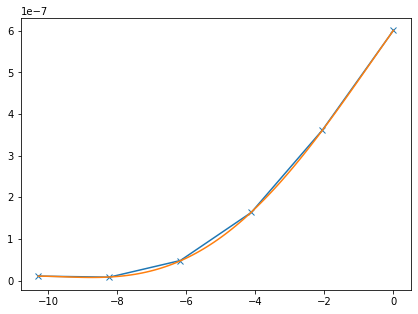

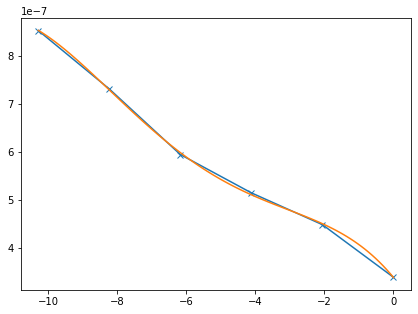

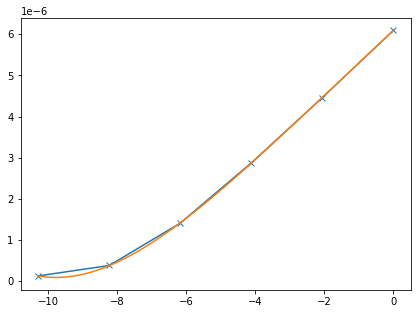

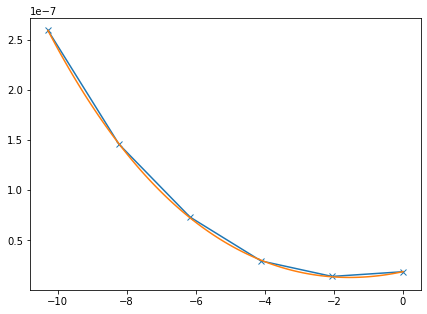

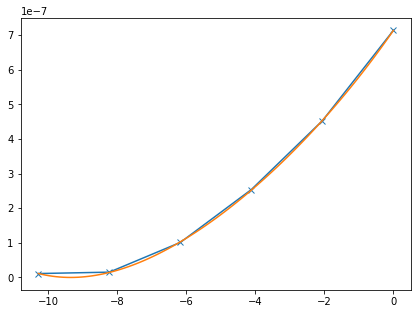

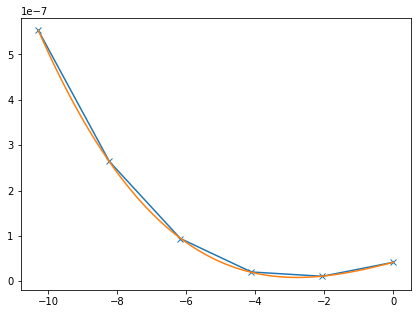

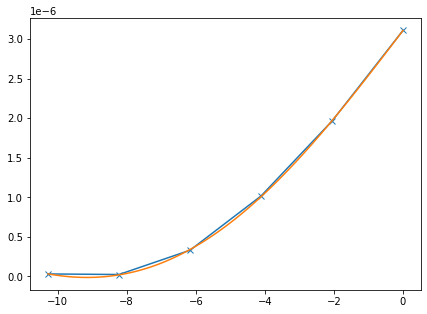

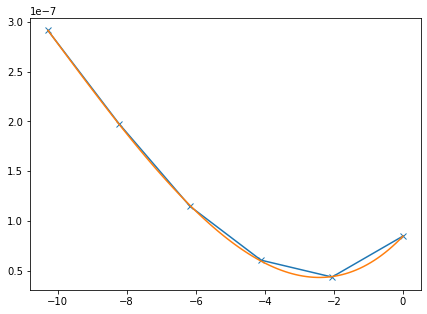

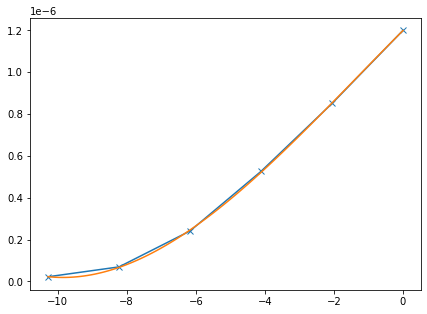

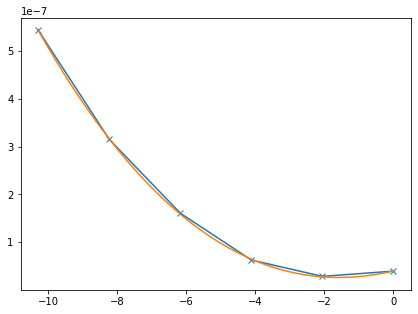

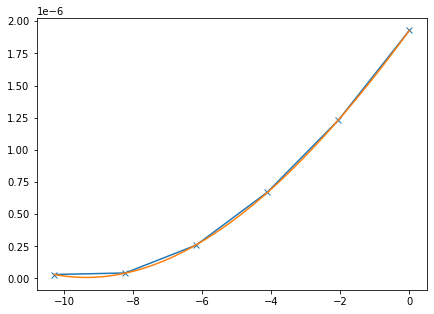

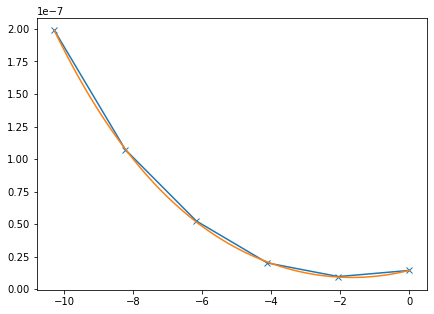

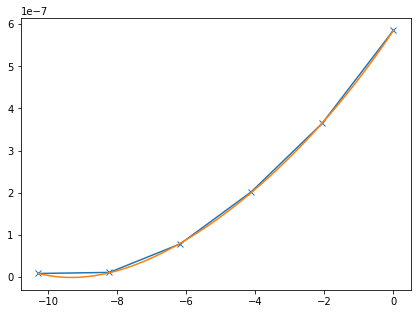

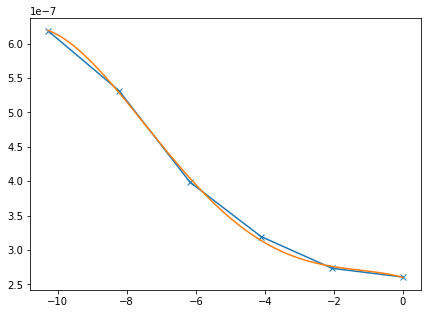

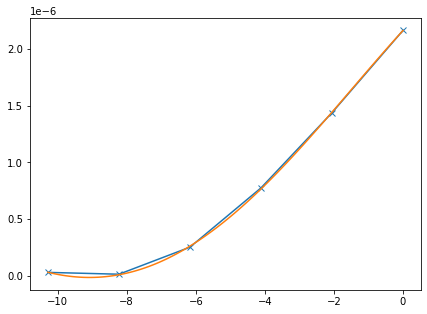

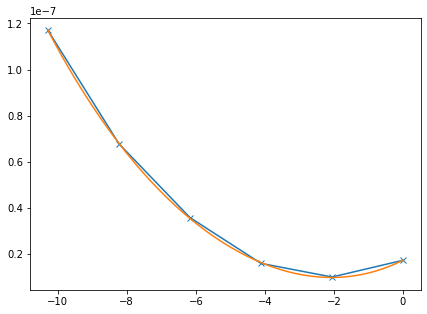

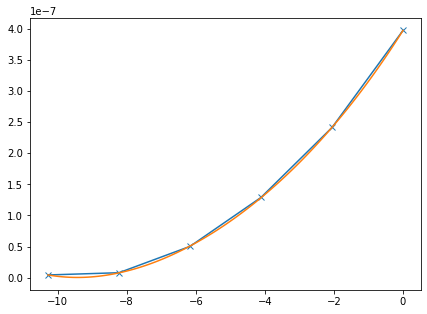

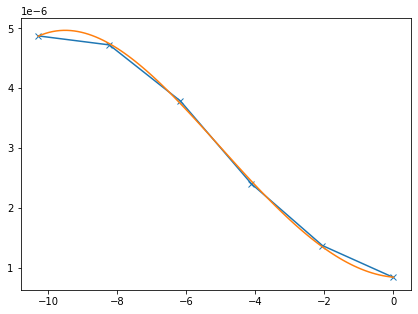

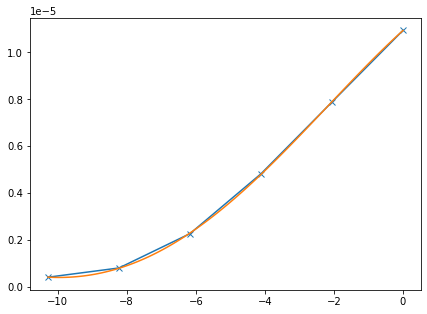

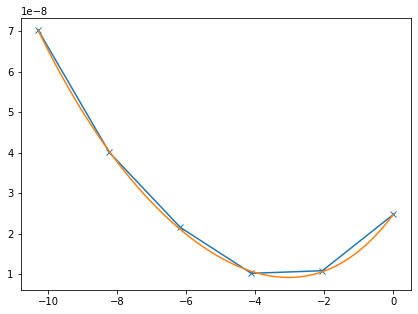

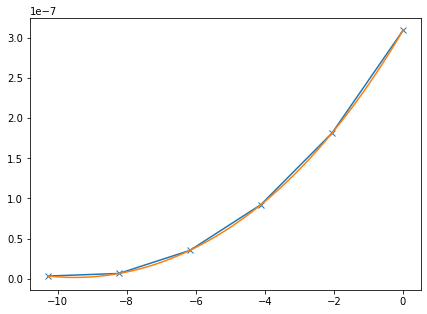

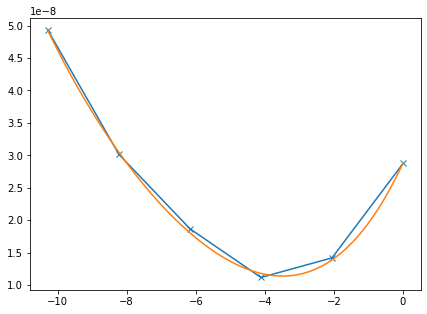

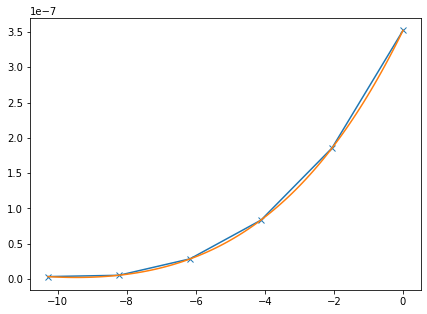

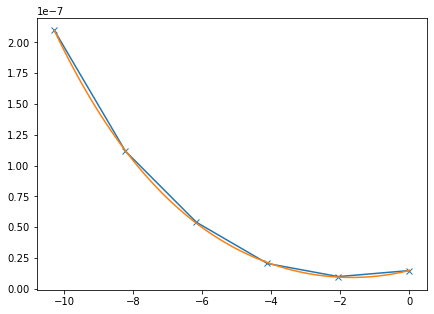

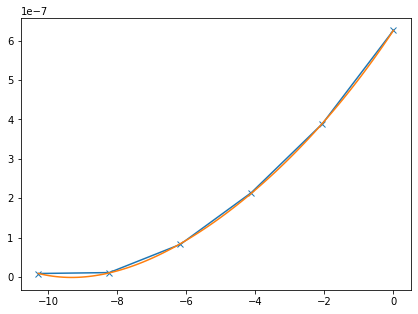

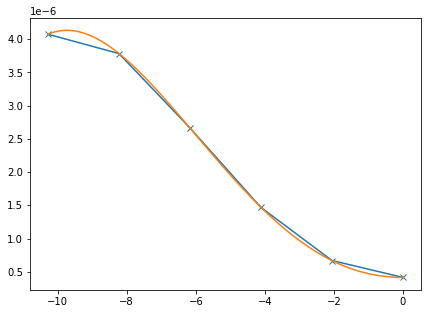

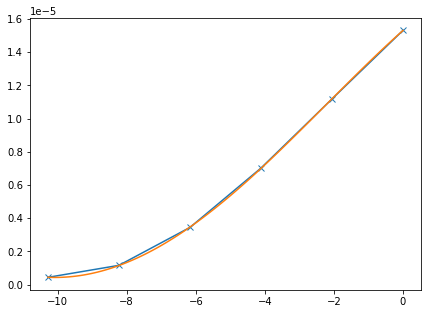

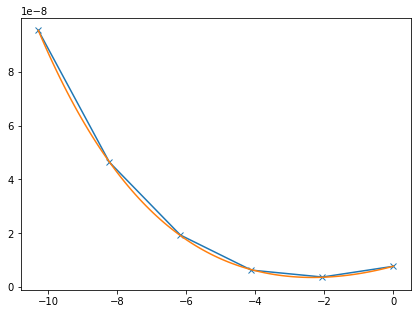

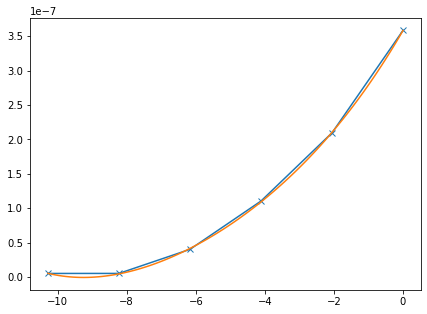

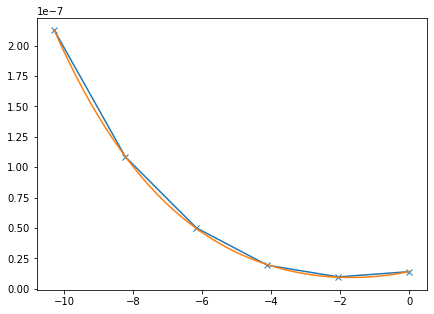

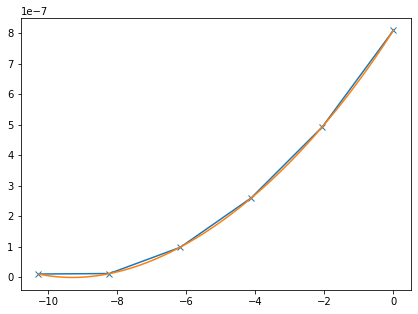

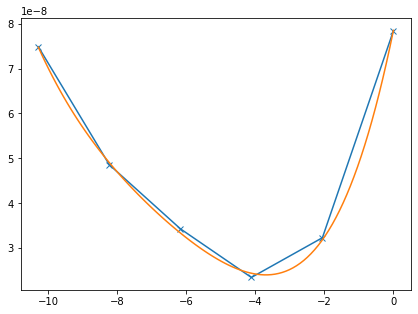

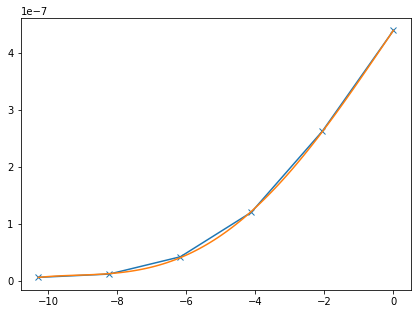

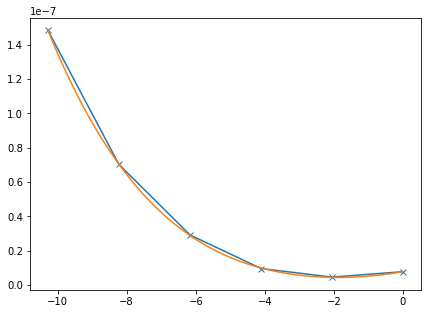

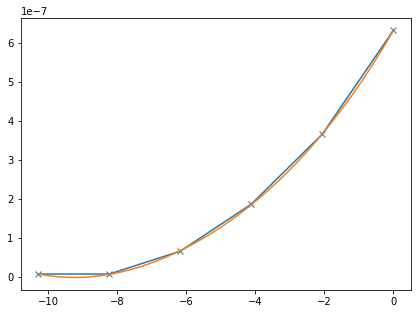

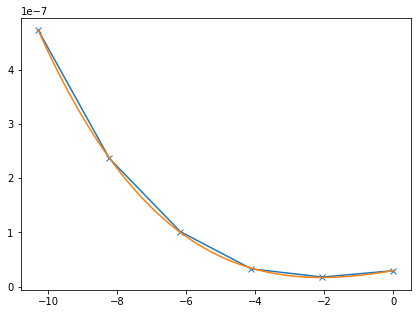

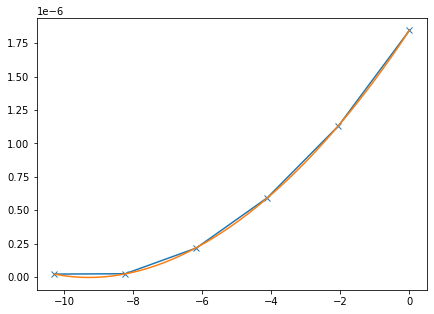

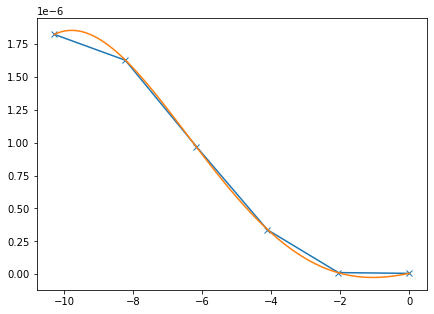

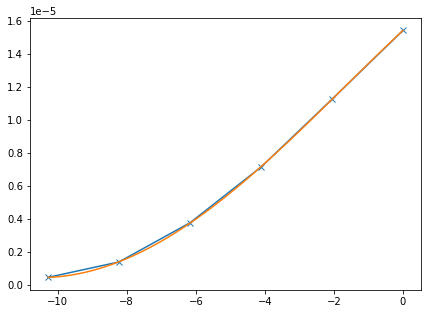

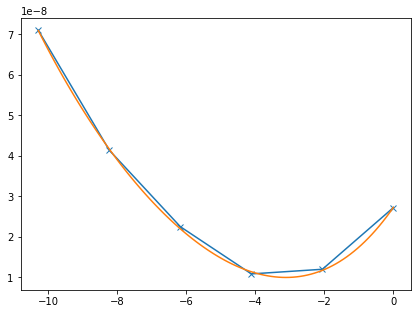

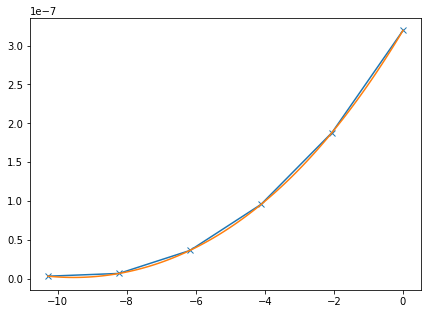

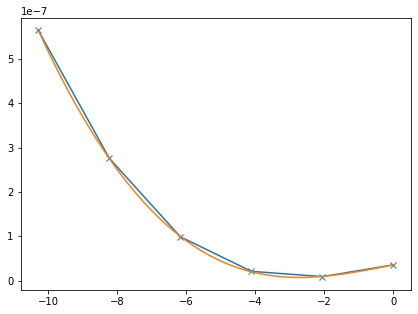

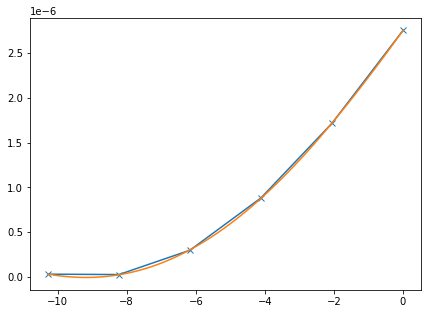

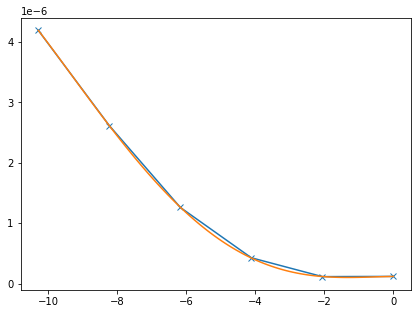

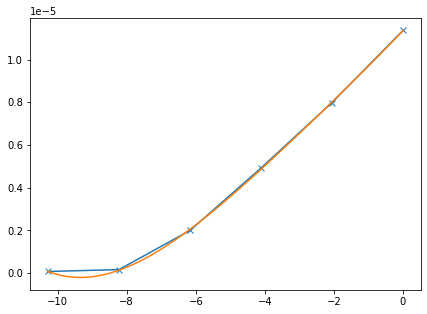

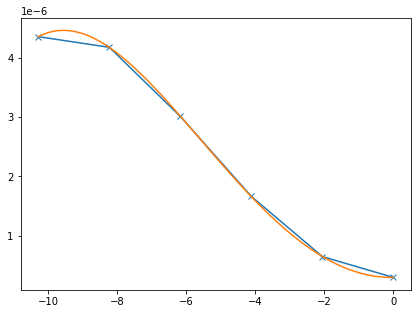

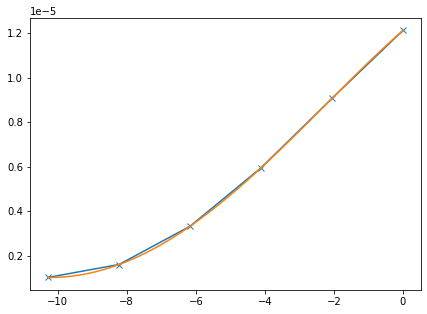

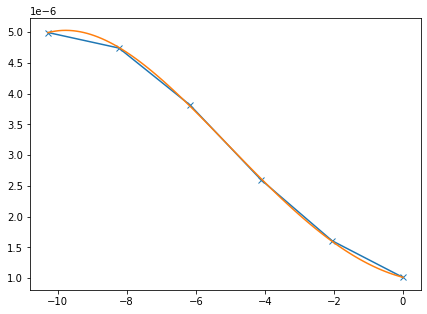

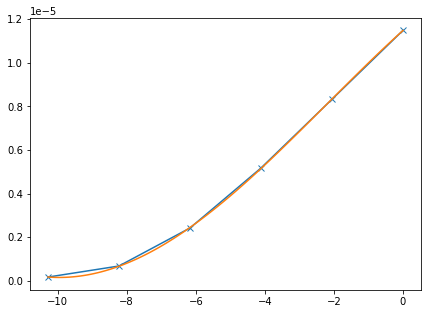

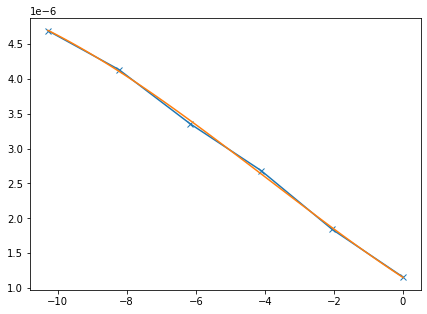

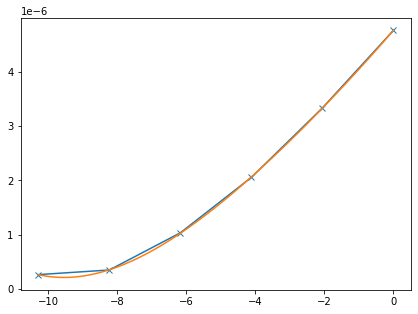

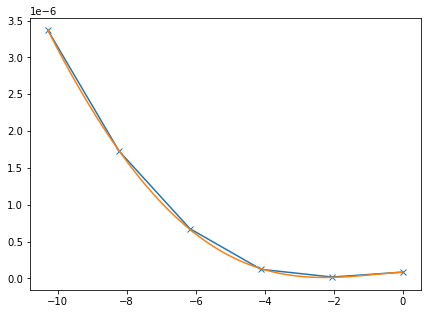

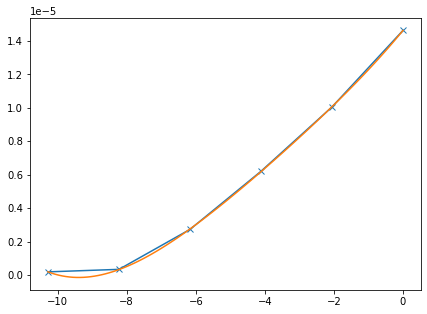

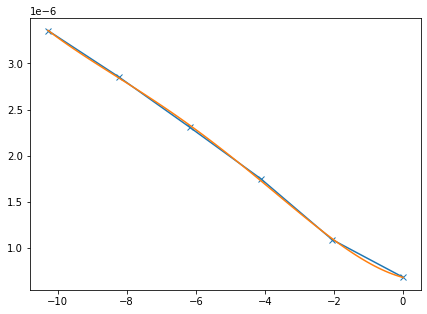

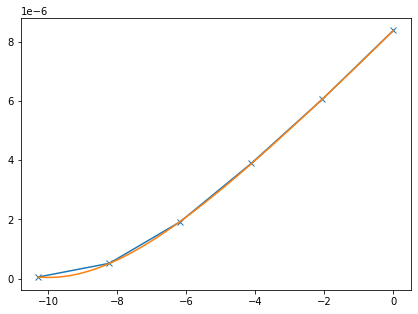

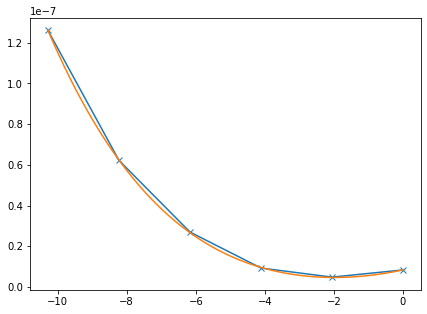

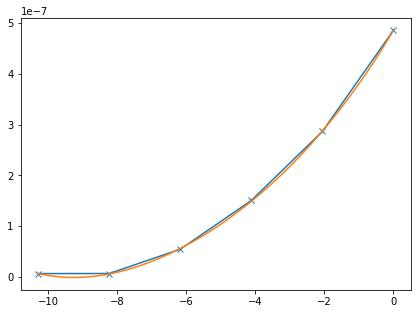

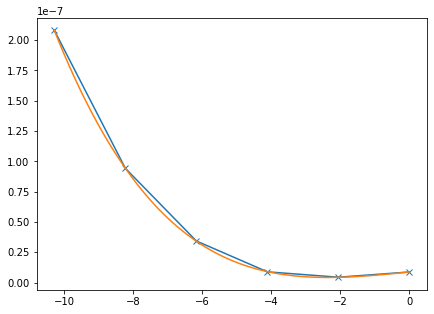

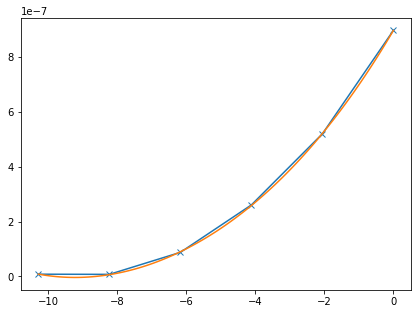

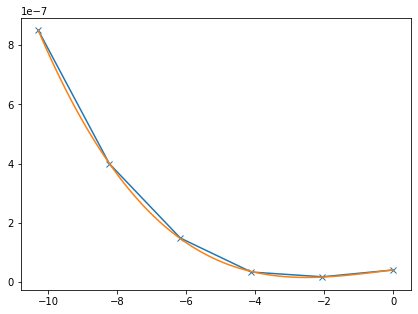

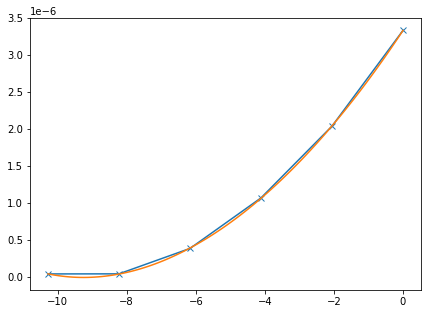

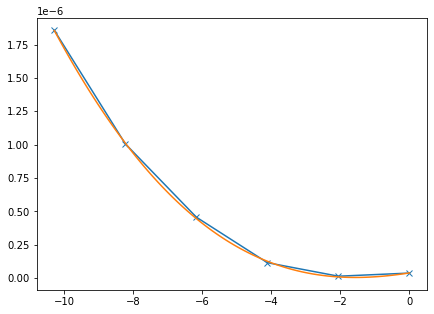

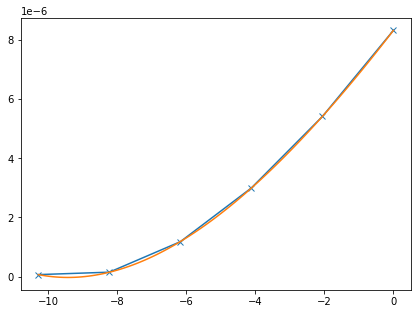

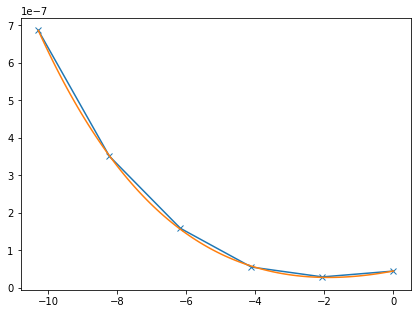

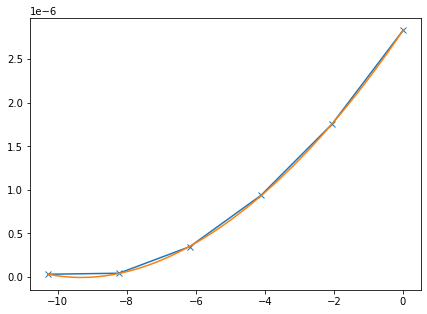

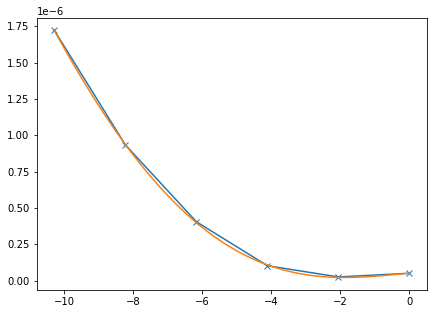

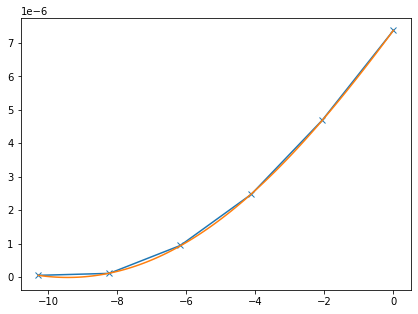

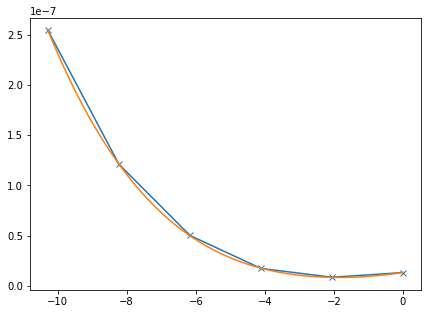

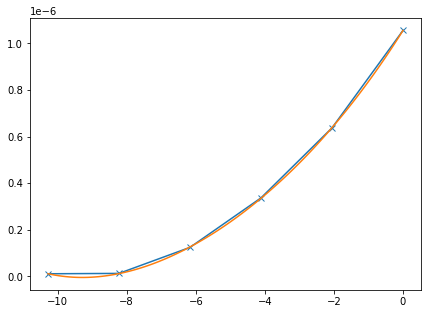

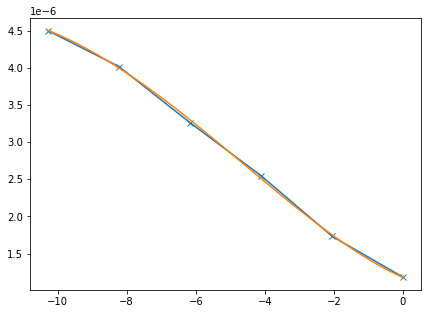

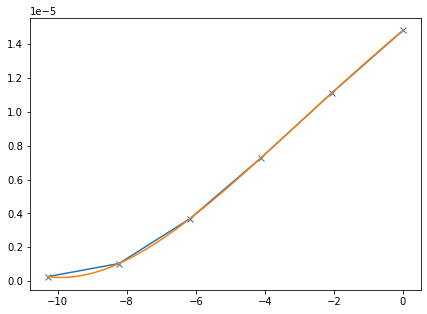

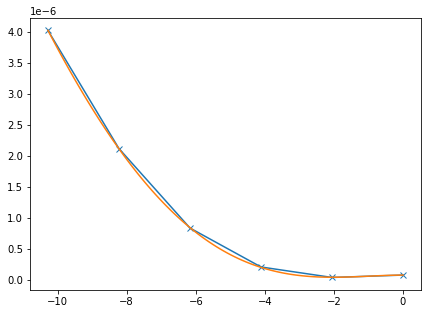

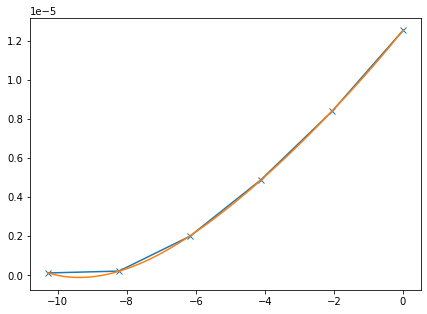

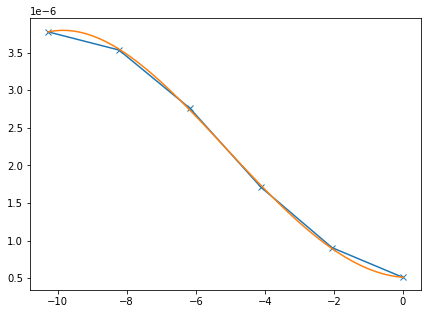

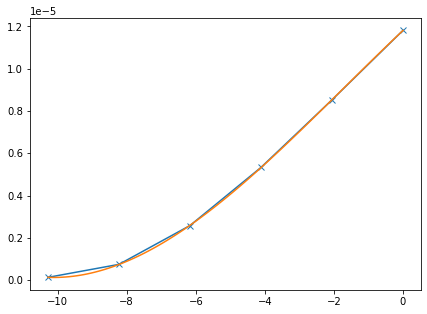

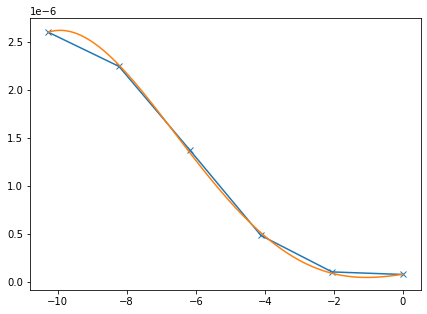

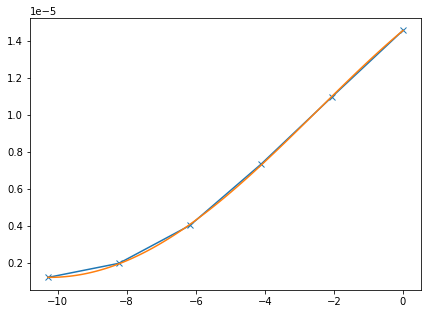

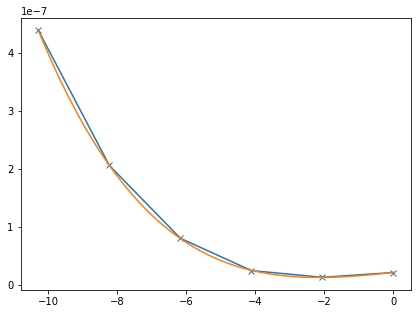

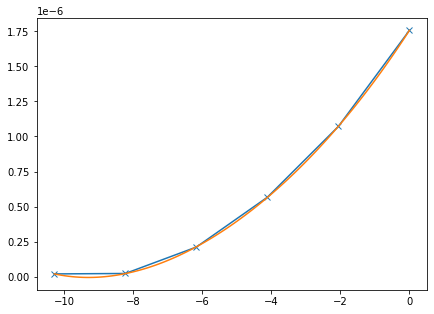

In [14]:
# bounds on input params 
pbounds = {'varx': (0.44, 0.55),
           'vary': (-0.02, 0.02),
           'varz': (-0.02, 0.02),
          }

optimizer = BayesianOptimization(
    f = evaluate,
    pbounds = pbounds,
    random_state = 1,
)

optimizer.maximize(
    init_points=5,
    n_iter=40,
)

## Results from simple BO

In [6]:
SOL_opt = optimizer.max['params']['varx'] # solenoid val at optimum
CQ_opt = optimizer.max['params']['vary'] # CQ val at optimum
SQ_opt = optimizer.max['params']['varz'] # SQ val at optimum

opt_emit = -1*optimizer.max['target'] # emittance value at optimum (in um)

print('optimum (pv_units) ',SOL_opt, CQ_opt, SQ_opt)
print('optimum geom emit ', opt_emit)

optimum (pv_units)  0.4783371750558134 -0.02 0.02
optimum geom emit  0.8672671914100647
